In [1]:
from sklearn.model_selection import train_test_split
import openml
import category_encoders as ce
import numpy as np
import sklearn

# Load SpeedDating dataset
dataset = openml.datasets.get_dataset(40536, download_data=True, download_qualities=True, download_features_meta_data=True)
X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
categorical_feature_indices = [idx for idx, idx_bool in enumerate(categorical_indicator) if idx_bool]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_valid))
print("Test set size:", len(X_test))

X_train.head()

Training set size: 5361
Validation set size: 1341
Test set size: 1676


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
813,0,3,female,23.0,21.0,2,[2-3],European/Caucasian-American,European/Caucasian-American,1,...,15.0,3.0,[0-4],[10-20],[3-5],5.0,10.0,[0-5],[7-10],0.0
1677,1,5,female,20.0,18.0,2,[2-3],Black/African American,Asian/Pacific Islander/Asian-American,0,...,NaN,3.0,[5-6],[0-3],[3-5],7.0,7.0,[6-8],[7-10],0.0
2915,1,9,female,28.0,27.0,1,[0-1],Black/African American,Asian/Pacific Islander/Asian-American,0,...,NaN,0.0,[7-10],[0-3],[0-2],NaN,NaN,[0-5],[0-4],NaN
5972,1,15,female,28.0,24.0,4,[4-6],European/Caucasian-American,European/Caucasian-American,1,...,NaN,1.0,[0-4],[0-3],[0-2],3.0,5.0,[0-5],[5-6],0.0
5443,1,14,male,23.0,24.0,1,[0-1],Asian/Pacific Islander/Asian-American,Other,0,...,NaN,4.0,[7-10],[0-3],[3-5],5.0,4.0,[0-5],[0-4],0.0


In [2]:
from GRANDE import GRANDE

params = {
        'depth': 6, # tree depth
        'n_estimators': 2048, # number of estimators / trees

        'learning_rate_weights': 0.005, # learning rate for leaf weights
        'learning_rate_index': 0.01, # learning rate for split indices
        'learning_rate_values': 0.01, # learning rate for split values
        'learning_rate_leaf': 0.01, # learning rate for leafs (logits)

        'optimizer': 'SWA', # optimizer
        'cosine_decay_steps': 0, # decay steps for lr schedule (CosineDecayRestarts)

        'loss': 'crossentropy', 
        'focal_loss': False,
        
        'transformation_type': 'mean', #for regression; mean log       
        
        'polyLoss': False,
        'polyLossEpsilon': 2.0,
        
        'weight_activation_st': 'softmax',
        'estimator_leaf_weights': True,

        'modify_grads': False,
        
        'logit_weights': False,
        #'weight_freeze_steps': 0,
        'warmup_steps': 0,
        
        'restarts': 0,
        'restart_type': 'loss', #'loss', 'metric'
        
        'early_stopping_epochs': 25,
        'early_stopping_type': 'loss', #'loss', 'metric'
        'early_stopping_epsilon': 1e-3,
        
        'class_weights': True,
        'model_seed': 1,
        
        'dropout': 0.0, # dropout rate (here, dropout randomly disables individual estimators of the ensemble during training)

        'selected_variables': 0.8, # feature subset percentage (0.0, 1.0)
        'data_subset_fraction': 1.0, # data subset percentage (0.0, 1.0)

        'reduce_lr': False,
        'reduce_lr_each_eval_nums': 10,
        'reduce_lr_fraction': 0.2,
        
        'initializer': 'RandomNormal', 
}

args = {
    'epochs': 100, # number of epochs for training
    'early_stopping_epochs': 25, # patience for early stopping (best weights are restored)
    'batch_size': 32,  # batch size for training

    'cat_idx': categorical_feature_indices, # put list of categorical indices
    'objective': 'binary',
    
    'random_seed': 42,
    'verbose': 1,       
}

model_grande = GRANDE(params=params, args=args)


2025-05-16 17:11:31.940055: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 17:11:31.974410: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 17:11:32.301460: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 17:11:32.304886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 17:11:33.462639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:

model_grande.fit(X_train=X_train,
          y_train=y_train,
          X_val=X_valid,
          y_val=y_valid)



Epoch 1/10


2025-05-16 17:11:42.685684: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x796a8400dd60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-05-16 17:11:42.685710: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-05-16 17:11:42.789852: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-16 17:11:43.515999: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


168/168 [==============================] - 152s 885ms/step - loss: 0.5676 - val_loss: 0.4501
Epoch 2/10
168/168 [==============================] - 149s 890ms/step - loss: 0.4012 - val_loss: 0.3661
Epoch 3/10
168/168 [==============================] - 146s 870ms/step - loss: 0.3355 - val_loss: 0.3456
Epoch 4/10
168/168 [==============================] - 144s 859ms/step - loss: 0.3159 - val_loss: 0.3420
Epoch 5/10
168/168 [==============================] - 146s 871ms/step - loss: 0.3085 - val_loss: 0.3421
Epoch 6/10
168/168 [==============================] - 148s 881ms/step - loss: 0.3028 - val_loss: 0.3432
Epoch 7/10
168/168 [==============================] - 149s 890ms/step - loss: 0.2986 - val_loss: 0.3442
Epoch 8/10
168/168 [==============================] - 146s 867ms/step - loss: 0.2945 - val_loss: 0.3447
Epoch 9/10
168/168 [==============================] - 146s 872ms/step - loss: 0.2908 - val_loss: 0.3462
Epoch 10/10
168/168 [==============================] - 143s 852ms/step - lo

In [ ]:
preds_grande = model_grande.predict(X_test)


In [22]:
def calculate_sample_weights(y_data):
    class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_data), y = y_data)
    sample_weights = sklearn.utils.class_weight.compute_sample_weight(class_weight = 'balanced', y =y_data)
    return sample_weights

In [ ]:
try:
    y_train = y_train.values.codes.astype(np.float64)
    y_valid = y_valid.values.codes.astype(np.float64)
    y_test = y_test.values.codes.astype(np.float64)
except:
    y_train = y_train.values.astype(np.float64)
    y_valid = y_valid.values.astype(np.float64)
    y_test = y_test.values.astype(np.float64)

In [24]:
binary_indices = []
low_cardinality_indices = []
high_cardinality_indices = []
num_columns = []
for column_index, column in enumerate(X_train.columns):
    if column_index in categorical_feature_indices:
        if len(X_train.iloc[:,column_index].unique()) <= 2:
            binary_indices.append(column)
        if len(X_train.iloc[:,column_index].unique()) < 5:
            low_cardinality_indices.append(column)
        else:
            high_cardinality_indices.append(column)
    else:
        num_columns.append(column)     
cat_columns = [col for col in X_train.columns if col not in num_columns]

In [25]:
if len(num_columns) > 0:
    mean_train_num = X_train[num_columns].mean(axis=0).iloc[0]
    X_train[num_columns] = X_train[num_columns].fillna(mean_train_num)
    X_valid[num_columns] = X_valid[num_columns].fillna(mean_train_num)
    X_test[num_columns] = X_test[num_columns].fillna(mean_train_num)
if len(cat_columns) > 0:
    mode_train_cat = X_train[cat_columns].mode(axis=0).iloc[0]
    X_train[cat_columns] = X_train[cat_columns].fillna(mode_train_cat)
    X_valid[cat_columns] = X_valid[cat_columns].fillna(mode_train_cat)
    X_test[cat_columns] = X_test[cat_columns].fillna(mode_train_cat)

X_train_raw = X_train.copy()
X_valid_raw = X_valid.copy()
X_test_raw = X_test.copy()

In [18]:
encoder_ordinal = ce.OrdinalEncoder(cols=binary_indices)
encoder_ordinal.fit(X_train)
X_train = encoder_ordinal.transform(X_train)
X_valid = encoder_ordinal.transform(X_valid)  
X_test = encoder_ordinal.transform(X_test)       

encoder = ce.LeaveOneOutEncoder(cols=high_cardinality_indices)
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_valid = encoder.transform(X_valid)
X_test = encoder.transform(X_test)

encoder = ce.OneHotEncoder(cols=low_cardinality_indices)
encoder.fit(X_train)
X_train = encoder.transform(X_train)
X_valid = encoder.transform(X_valid)
X_test = encoder.transform(X_test)

X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test = X_test.astype(np.float32)

In [19]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Define model parameters for CPU-based training
xgb_params = {
    'n_estimators': 1000,
    'early_stopping_rounds': 20,
    'tree_method': 'hist',            # CPU histogram-based algorithm
    'eval_metric': 'logloss',         # Suitable for classification
    'use_label_encoder': False,       # Avoids label encoding warning
    'random_state': 42                # Ensures reproducibility
}

# Initialize model
model_xgb = XGBClassifier(**xgb_params)

# Train with evaluation set and sample weights
model_xgb.fit(
    X_train,
    y_train,
    sample_weight=calculate_sample_weights(y_train),
    eval_set=[(X_valid, y_valid)],
    sample_weight_eval_set=[compute_sample_weight(class_weight='balanced', y=y_valid)],
    verbose=False  # Set to True for training logs
)

# Predict class probabilities for classification
preds_xgb = model_xgb.predict_proba(X_test)


/home/saad/miniconda3/envs/dwh/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:37:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


In [ ]:
from catboost import CatBoostClassifier, Pool

model_catboost = CatBoostClassifier(n_estimators=1000, 
                                    early_stopping_rounds=20)
train_data = Pool(
        data=X_train_raw,
        label=y_train,
        cat_features=categorical_feature_indices,
        weight=calculate_sample_weights(y_train)
    )

eval_data = Pool(
        data=X_valid_raw,
        label=y_valid,
        cat_features=categorical_feature_indices,
        weight=calculate_sample_weights(y_valid),
    )

model_catboost.fit(X=train_data, 
                   eval_set=eval_data)

if args['objective'] == 'regression':
    preds_catboost = model_catboost.predict(X_test_raw)
else:
    preds_catboost = model_catboost.predict_proba(X_test_raw)


/tmp/ipykernel_7698/2120585526.py:115: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7698/2120585526.py:115: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7698/2120585526.py:115: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7698/2120585526.py:115: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7698/2120585526.py:115: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7698/2120585526.py:133: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.savefig(f'model_comparison.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_7698/2120585526.py:133: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing fro


📋 Model Performance Metrics:
           GRANDE  XGBoost  CatBoost
Accuracy  0.8365   0.7703    0.7906
F1 Score  0.6821   0.6809    0.7106
ROC AUC   0.8404   0.8039    0.8575


/home/saad/miniconda3/envs/dwh/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/saad/miniconda3/envs/dwh/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/saad/miniconda3/envs/dwh/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/saad/miniconda3/envs/dwh/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/saad/miniconda3/envs/dwh/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) miss

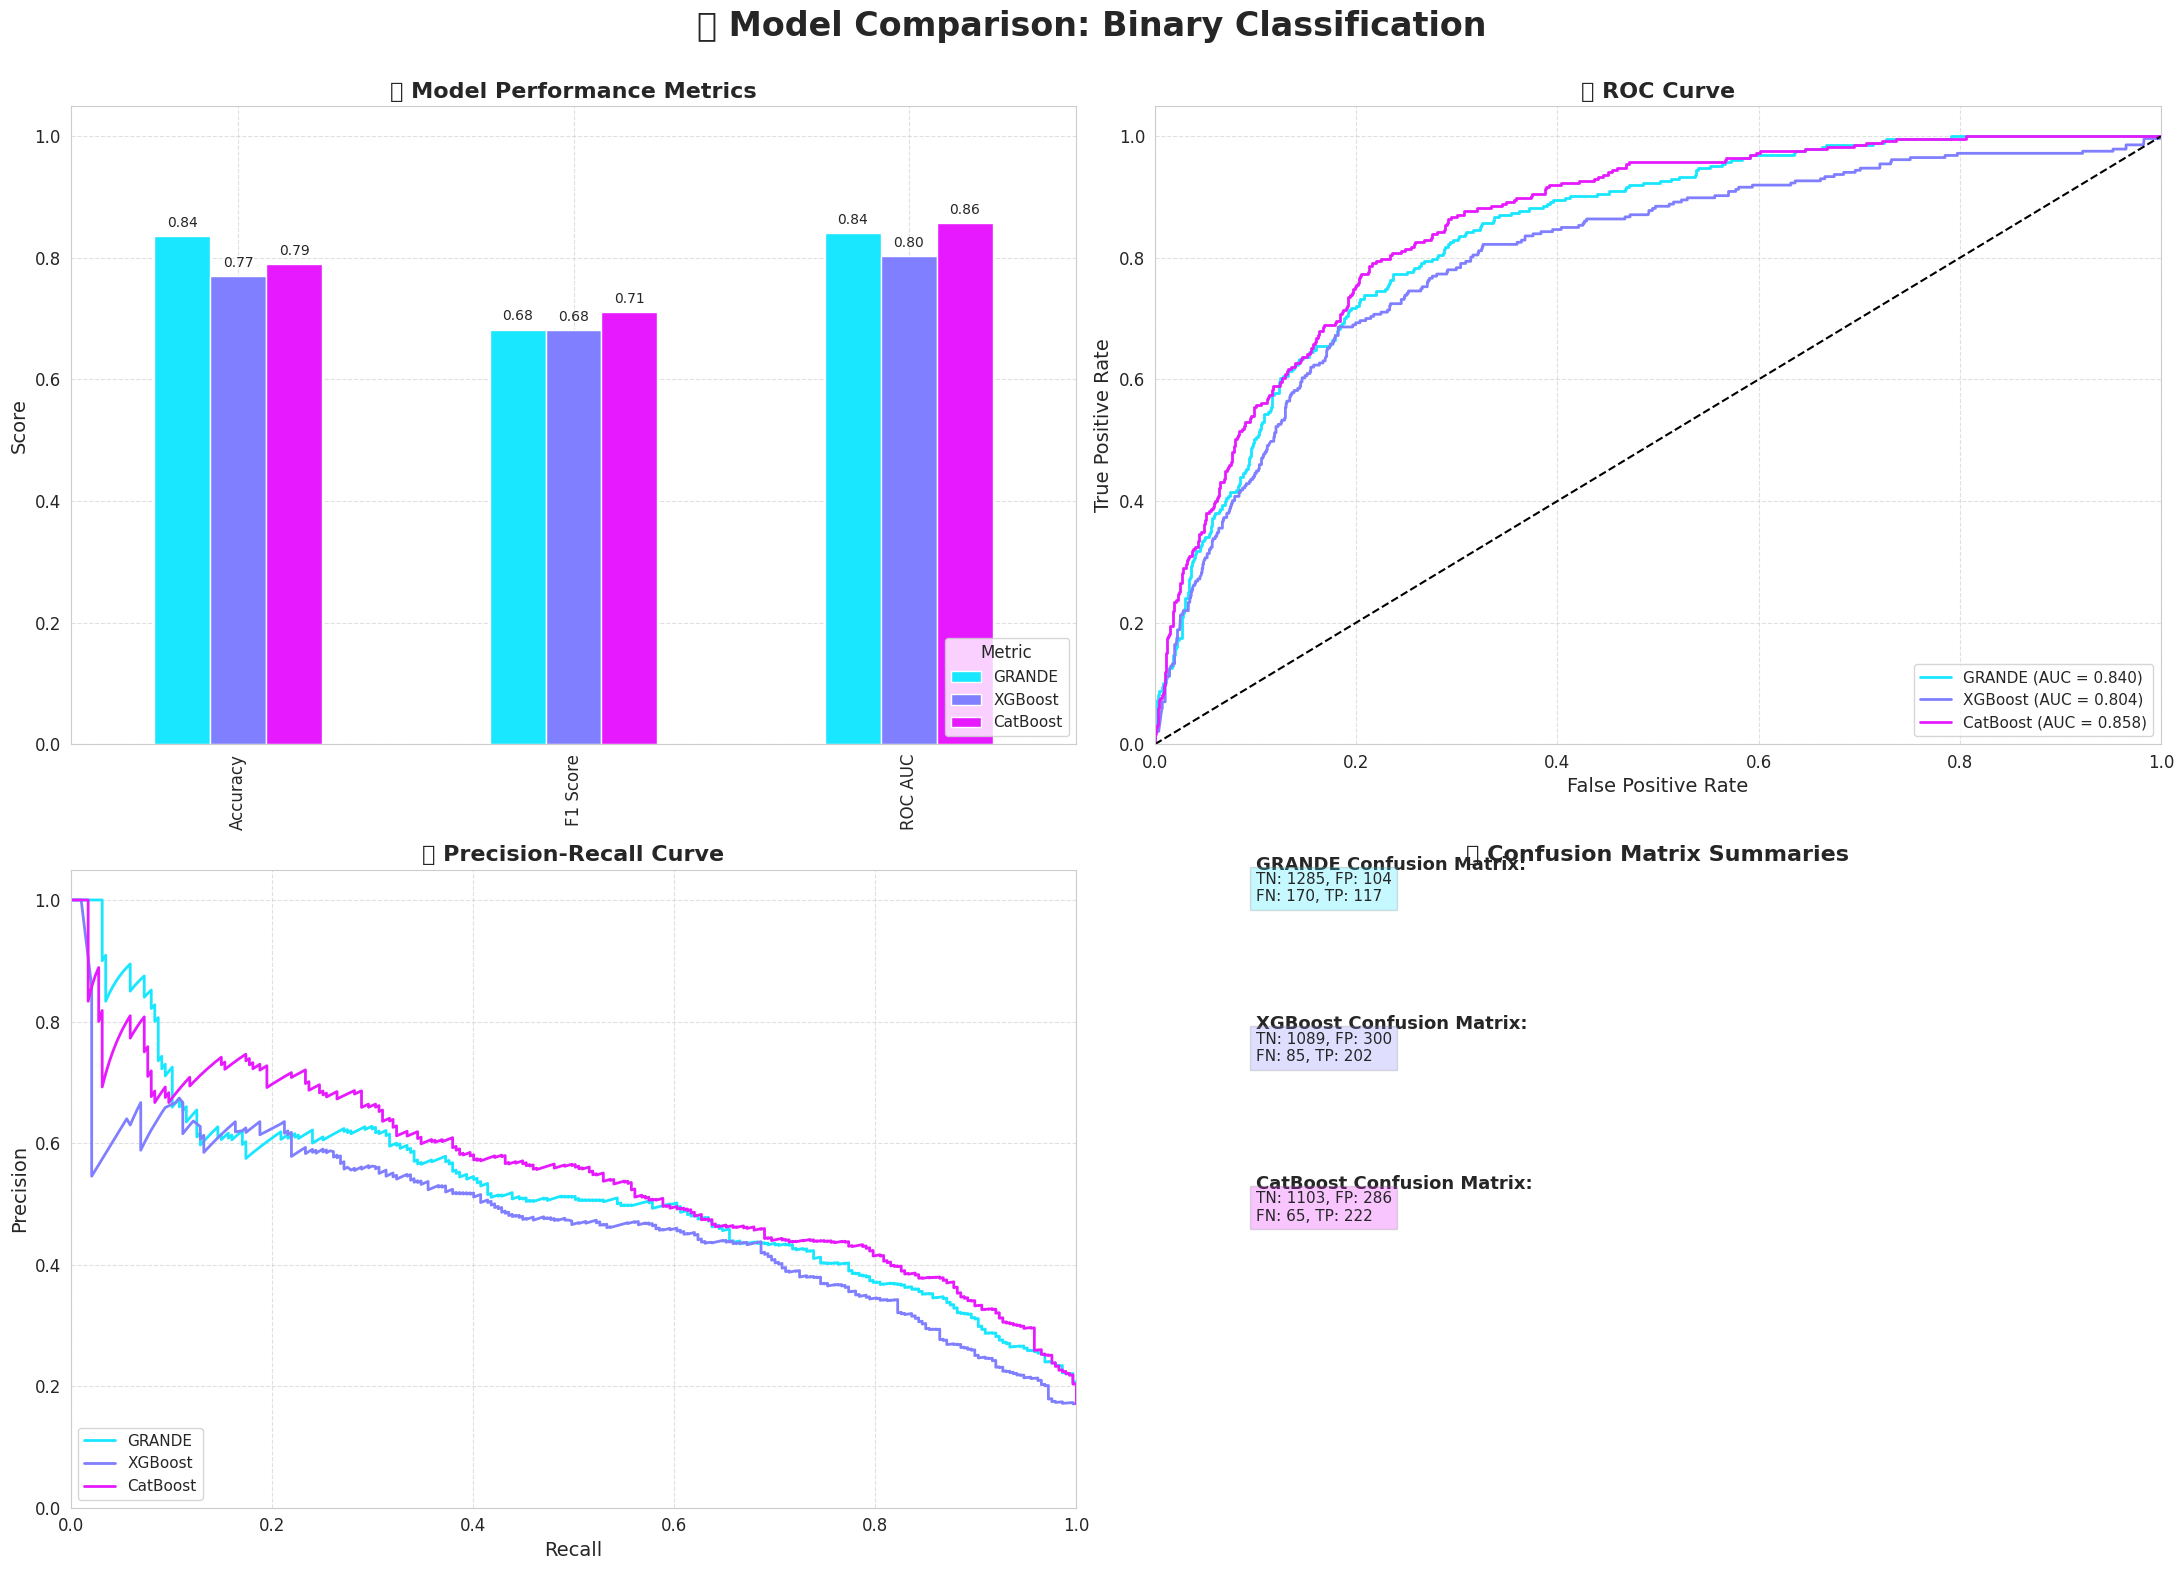

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix
)

def visualize_model_comparison(y_test, preds_dict):
    """
    Visual comparison of binary classification models:
    Includes metrics, ROC, PR curves, and confusion matrices.
    """
    # Styling
    sns.set_style("whitegrid")
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'legend.fontsize': 11,
        'figure.titlesize': 20
    })

    # Use visually appealing cool color palette
    cmap = plt.cm.cool
    colors = cmap(np.linspace(0.1, 0.9, len(preds_dict)))

    fig, axs = plt.subplots(2, 2, figsize=(22, 16))
    fig.suptitle('📊 Model Comparison: Binary Classification', fontsize=24, weight='bold')

    # Store metrics
    metrics = {
        'Accuracy': {},
        'F1 Score': {},
        'ROC AUC': {}
    }

    # Plot for each model
    for i, (model_name, preds) in enumerate(preds_dict.items()):
        if preds.shape[1] != 2:
            raise ValueError(f"{model_name} should return probas for both classes (shape = [n_samples, 2])")

        prob_1 = preds[:, 1]
        pred_labels = np.round(prob_1)

        # Compute metrics
        metrics['Accuracy'][model_name] = accuracy_score(y_test, pred_labels)
        metrics['F1 Score'][model_name] = f1_score(y_test, pred_labels, average='macro')
        metrics['ROC AUC'][model_name] = roc_auc_score(y_test, prob_1)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, prob_1)
        axs[0, 1].plot(fpr, tpr, lw=2, color=colors[i],
                       label=f'{model_name} (AUC = {metrics["ROC AUC"][model_name]:.3f})')

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, prob_1)
        axs[1, 0].plot(recall, precision, lw=2, color=colors[i], label=model_name)

        # Confusion Matrix Summary
        cm = confusion_matrix(y_test, pred_labels)
        y_offset = 1.0 - (i * 0.25)
        axs[1, 1].text(0.1, y_offset, f"{model_name} Confusion Matrix:",
                       fontsize=13, fontweight='bold', transform=axs[1, 1].transAxes)
        axs[1, 1].text(0.1, y_offset - 0.05,
                       f"TN: {cm[0,0]}, FP: {cm[0,1]}\nFN: {cm[1,0]}, TP: {cm[1,1]}",
                       fontsize=11, transform=axs[1, 1].transAxes,
                       bbox=dict(facecolor=colors[i], alpha=0.25, edgecolor='gray'))

    # Convert to DataFrame for bar plot
    metrics_df = pd.DataFrame(metrics).T  # models as rows
    bar_ax = axs[0, 0]
    bar_df = metrics_df.copy()
    bar_df.plot(kind='bar', ax=bar_ax, color=colors)
    bar_ax.set_ylim(0, 1.05)
    bar_ax.set_ylabel('Score')
    bar_ax.set_title('🔍 Model Performance Metrics', fontsize=16, weight='bold')
    bar_ax.grid(True, linestyle='--', alpha=0.6)
    bar_ax.legend(title="Metric", loc='lower right')

    # Add score annotations
    for p in bar_ax.patches:
        bar_ax.annotate(f"{p.get_height():.2f}",
                        (p.get_x() + p.get_width() / 2., p.get_height() + 0.01),
                        ha='center', va='bottom', fontsize=10)

    # ROC settings
    axs[0, 1].plot([0, 1], [0, 1], 'k--', lw=1.5)
    axs[0, 1].set_xlim(0, 1.0)
    axs[0, 1].set_ylim(0, 1.05)
    axs[0, 1].set_xlabel('False Positive Rate')
    axs[0, 1].set_ylabel('True Positive Rate')
    axs[0, 1].set_title('📈 ROC Curve', fontsize=16, weight='bold')
    axs[0, 1].legend(loc='lower right')
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)

    # PR settings
    axs[1, 0].set_xlim(0, 1.0)
    axs[1, 0].set_ylim(0, 1.05)
    axs[1, 0].set_xlabel('Recall')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_title('📉 Precision-Recall Curve', fontsize=16, weight='bold')
    axs[1, 0].legend(loc='lower left')
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)

    # Confusion Matrix settings
    axs[1, 1].set_title('🧮 Confusion Matrix Summaries', fontsize=16, weight='bold')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    print("\n📋 Model Performance Metrics:\n", metrics_df.round(4))

    return metrics_df

    
# 2. Prepare dictionary of model predictions
predictions = {
    'GRANDE': preds_grande,
    'XGBoost': preds_xgb,
    'CatBoost': preds_catboost
}

# 3. Visualize results
metrics_df = visualize_model_comparison(y_test, predictions)

# 4. Save plot if needed
plt.savefig(f'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Export metrics to CSV if needed
metrics_df.to_csv(f'model_metrics.csv')

In [ ]:
accuracy = sklearn.metrics.accuracy_score(y_test, np.round(preds_grande[:,1]))
f1_score = sklearn.metrics.f1_score(y_test, np.round(preds_grande[:,1]), average='macro')
roc_auc = sklearn.metrics.roc_auc_score(y_test, preds_grande[:,1], average='macro', multi_class='ovo')

print('Accuracy GRANDE:', accuracy)
print('F1 Score GRANDE:', f1_score)
print('ROC AUC GRANDE:', roc_auc)
print('\n')

accuracy = sklearn.metrics.accuracy_score(y_test, np.round(preds_xgb[:,1]))
f1_score = sklearn.metrics.f1_score(y_test, np.round(preds_xgb[:,1]), average='macro')
roc_auc = sklearn.metrics.roc_auc_score(y_test, preds_xgb[:,1], average='macro', multi_class='ovo')

print('Accuracy XGB:', accuracy)
print('F1 Score XGB:', f1_score)
print('ROC AUC XGB:', roc_auc)
print('\n')

accuracy = sklearn.metrics.accuracy_score(y_test, np.round(preds_catboost[:,1]))
f1_score = sklearn.metrics.f1_score(y_test, np.round(preds_catboost[:,1]), average='macro')
roc_auc = sklearn.metrics.roc_auc_score(y_test, preds_catboost[:,1], average='macro', multi_class='ovo')

print('Accuracy CatBoost:', accuracy)
print('F1 Score CatBoost:', f1_score)
print('ROC AUC CatBoost:', roc_auc)
print('\n')

Accuracy GRANDE: 0.8365155131264916
F1 Score GRANDE: 0.6821433713190915
ROC AUC GRANDE: 0.8403985520879583


Accuracy XGB: 0.7702863961813843
F1 Score XGB: 0.6809129826966279
ROC AUC XGB: 0.8038721362221335


Accuracy CatBoost: 0.7905727923627685
F1 Score CatBoost: 0.7106101637384612
ROC AUC CatBoost: 0.8575216421710652


